In [2]:
from gdeep.topactivation import TopactivationFC as TFC
from gdeep.pipeline import Pipeline
from torch.utils.tensorboard import SummaryWriter

from gdeep.models import FFNet
from torch import nn
import torch
from gdeep.data import TorchDataLoader

!pip3 install xitorch
from gdeep.models import ModelExtractor
from gdeep.topactivation.spectral_analysisTorch import LaplacianOperator
import matplotlib.pyplot as plt 

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU!")
else:
    DEVICE = torch.device("cpu")


def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')

Using GPU!
Using GPU!
Using GPU!
No TPUs...
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Using GPU!


In [129]:
#Trainig the model 

writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)


#cpu = torch.ones(1).device


arch = [28*28,28*28,28*28]

model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))





In [127]:
for sample,_ in dl_tr:
    break
pipe2=Pipeline(model, (train_loader, test_loader), loss_fn, writer)
me2 = ModelExtractor(pipe2.model, pipe2.loss_fn)
activations = me2.get_activations(sample)
[x.shape for x in activations]

[torch.Size([32, 784]),
 torch.Size([32, 3]),
 torch.Size([32, 2]),
 torch.Size([32, 2]),
 torch.Size([32, 2])]

In [130]:
from tqdm import tqdm 
dset = {'train' : [],'test':[]}
for data,label in tqdm(dl_tr):
    for i in range(len(data)):
        dset['train'].append((data[i][0],torch.rot90(data[i][0]).reshape(28*28)))

for data,label in dl_ts:
    for i in range(len(data)):
        dset['test'].append((data[i][0],torch.rot90(data[i][0]).reshape(28*28)))


100%|██████████████████████████████████████| 1875/1875 [00:05<00:00, 338.33it/s]


In [131]:
train_loader = torch.utils.data.DataLoader(dset['train'], batch_size=32, shuffle=True, num_workers=6)
test_loader = torch.utils.data.DataLoader(dset['test'], batch_size=32, shuffle=True, num_workers=6)

In [41]:
dset['train'][0][0].shape

torch.Size([28, 28])

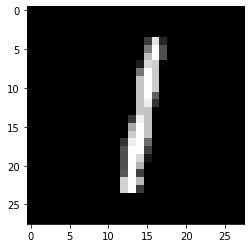

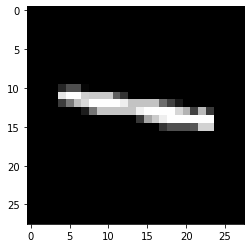

In [132]:
for x,y in train_loader:
    print28x28tensor(x[0])
    plt.show()
    print28x28tensor(y[0])
    #print28x28tensor(y[0])
    break

In [154]:

#pipe = Pipeline(model, (train_loader, test_loader), loss_fn, writer)


epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
lr = 0.01


for epoch in tqdm(range(epochs)):
    #Train : 
    #pipe.train(optimizer, epochs, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    running_loss=0.0
    for data,target in train_loader:
        optimizer.zero_grad()

        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
    
    
    
   
me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())


 10%|████▍                                       | 1/10 [00:07<01:09,  7.72s/it]

[1,    32] loss: 0.024


 20%|████████▊                                   | 2/10 [00:15<01:01,  7.68s/it]

[2,    32] loss: 0.024


 30%|█████████████▏                              | 3/10 [00:22<00:53,  7.61s/it]

[3,    32] loss: 0.023


 40%|█████████████████▌                          | 4/10 [00:30<00:45,  7.59s/it]

[4,    32] loss: 0.023


 50%|██████████████████████                      | 5/10 [00:37<00:37,  7.53s/it]

[5,    32] loss: 0.023


 60%|██████████████████████████▍                 | 6/10 [00:45<00:30,  7.57s/it]

[6,    32] loss: 0.022


 70%|██████████████████████████████▊             | 7/10 [00:53<00:22,  7.55s/it]

[7,    32] loss: 0.022


 80%|███████████████████████████████████▏        | 8/10 [01:00<00:15,  7.56s/it]

[8,    32] loss: 0.022


 90%|███████████████████████████████████████▌    | 9/10 [01:08<00:07,  7.64s/it]

[9,    32] loss: 0.021


100%|███████████████████████████████████████████| 10/10 [01:16<00:00,  7.62s/it]

[10,    32] loss: 0.021


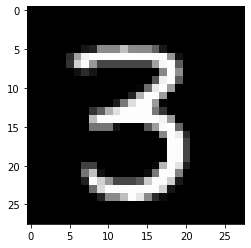

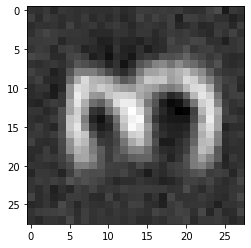

In [156]:
for x,y in train_loader:
    print28x28tensor(x[0])
    plt.show()
    print28x28tensor(model(x.to(DEVICE))[0].detach())
    #print28x28tensor(y[0])
    break

In [159]:
pipe = Pipeline(model, (train_loader, test_loader), loss_fn, writer)

In [162]:
epsilon = 0.1
n_batch = 300 #Number of batch used to generate the dataset 
activ = torch.zeros((3,n_batch*32,sum(arch)))
#final tensor activ[alter][idx] contains an activation vector for data sample idx with a specific alteration :
# 0 : no alteration, raw data 
# 1 : data + adversarial  noise
# 2 : data + shuffle of adversarial noise (random perturbation with same statistics)
label = torch.zeros(n_batch*32)


topactiv = TFC(pipe,arch)
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

k_batch = 0 
for data, target in tqdm(train_loader): 
    
    
    data=data.to(DEVICE) ##SUBOPTIMAL !!!
    target = target.to(DEVICE)
    data_perturbed = topactiv.fgsm_attack(data, target,epsilon)
    
    #data_noised = data+epsilon*2*(torch.bernoulli(0.5*torch.ones(data.shape))-1)
    #Shuffle
    data_noised = torch.zeros(32,1,28,28).to(DEVICE)
    for i in range(32):
        indices=torch.randperm(784).to(DEVICE)
        data_noised[i]=(data_perturbed-data)[i].reshape(784)[indices].reshape(1,28,28)+data[i]
    
    
    normal_activation = torch.cat(me.get_activations(data)[:-2],dim=1)
    perturbed_activation = torch.cat(me.get_activations(data_perturbed)[:-2],dim=1)
    noised_activation= torch.cat(me.get_activations(data_noised)[:-2],dim=1)

    
    activ[0][k_batch*32:(k_batch+1)*32]=normal_activation
    activ[1][k_batch*32:(k_batch+1)*32]=perturbed_activation
    activ[2][k_batch*32:(k_batch+1)*32]=noised_activation
    #label[k_batch*32:(k_batch+1)*32]=
    
    k_batch+=1
    if k_batch>=n_batch:
        break 

 16%|██████▏                                | 299/1875 [00:02<00:13, 117.35it/s]


In [140]:
for x in pipe.model.modules():
    print('ok')
    print(x)

ok
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): FFNet(
    (linears): ModuleList(
      (0): Linear(in_features=784, out_features=784, bias=False)
      (1): Linear(in_features=784, out_features=784, bias=False)
    )
  )
)
ok
Flatten(start_dim=1, end_dim=-1)
ok
FFNet(
  (linears): ModuleList(
    (0): Linear(in_features=784, out_features=784, bias=False)
    (1): Linear(in_features=784, out_features=784, bias=False)
  )
)
ok
ModuleList(
  (0): Linear(in_features=784, out_features=784, bias=False)
  (1): Linear(in_features=784, out_features=784, bias=False)
)
ok
Linear(in_features=784, out_features=784, bias=False)
ok
Linear(in_features=784, out_features=784, bias=False)


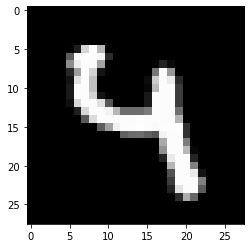

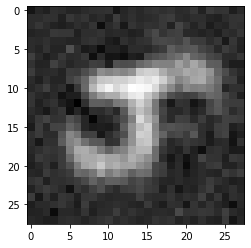

In [164]:
for x,y in train_loader:
    print28x28tensor(x[0])
    plt.show()
    print28x28tensor(pipe.model(x.to(DEVICE))[0].detach())
    #print28x28tensor(y[0])
    break

In [165]:
idx = torch.randint(low=0,high=activ[0].shape[0],size=(1,))

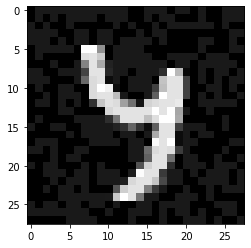

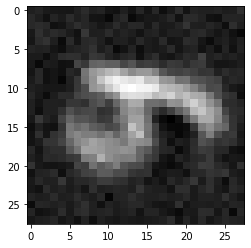

In [168]:
alter = 1
print28x28tensor(activ[alter][idx,:28*28])
plt.show()
print28x28tensor(activ[alter][idx,-28*28:])
plt.show()
#print28x28tensor(activ[1][idx,:28*28])
#print28x28tensor(activ[1][idx,:28*28])

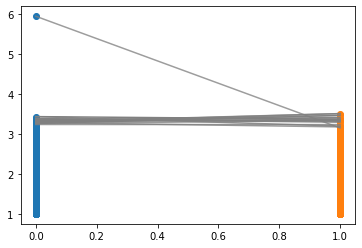

In [173]:
#Effective network visualisation
me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())
    

from scipy.linalg import null_space
S = []
V = []
U = []
K = []
for layer in weights:
    u,s,v= torch.svd(layer)
    U.append(u.to('cpu'))
    S.append(s.to('cpu'))
    V.append(v.to('cpu'))
    K.append(null_space(layer.to('cpu')))


adjacency = [V[i+1].T@U[i]@torch.diag(S[i]) for i in range(len(arch)-2)]

def y_scale(x):
    return torch.exp(x)

#Nodes 
for i in range(len(S)):
    plt.scatter(len(S[i])*[i],y_scale(S[i]))
    
#Edges  
for k in range(len(adjacency)):
    E = torch.abs(adjacency[k])
    for i in range(E.shape[0]):
        for j in range(E.shape[1]):
            if E[i,j]>3e-1:
                plt.plot([k,k+1],[y_scale(S[k][j]),y_scale(S[k+1][i])],color='grey',alpha=((E[i,j]/E.max())**0.5).item()) #Peut-être j,i
plt.show()

In [171]:
len(weights)

2